In [48]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Layer
import numpy as np
import tensorflow_hub as hub
import tensorflow_datasets as tfds


sound_vocab = {"<pad>": 0, "cat": 1, "dog": 2, "meow": 3, "bark": 4}
inv_sound_vocab = {v: k for k, v in sound_vocab.items()}
animal_vocab = {"<pad>": 0, "cat": 1, "dog": 2}
inv_animal_vocab = {v: k for k, v in animal_vocab.items()}

dummy_text = "<empty>"
dummy_image = np.zeros((224,224,3), dtype=np.float32)

# Text expert
class HubEmbeddingLayer(Layer):
    def __init__(self, hub_url="https://tfhub.dev/google/universal-sentence-encoder/4"):
        super().__init__()
        self.hub_layer = hub.KerasLayer(hub_url, trainable=True)
    def call(self, inputs):
        return self.hub_layer(inputs)

def build_text_expert():
    inp = Input(shape=(), dtype=tf.string)
    x = HubEmbeddingLayer()(inp)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(len(sound_vocab))(x)
    return Model(inp, out, name="TextExpert")

# Image expert
def build_image_expert():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3), include_top=False,
                                                   weights="imagenet", pooling="avg")
    base_model.trainable = False
    inp = Input(shape=(224,224,3))
    x = base_model(inp)
    x = layers.Dense(128, activation="relu")(x)
    out = layers.Dense(len(animal_vocab))(x)
    return Model(inp, out, name="ImageExpert")

# Deterministic gating layer selecting expert by presence flags
class GateLayer(Layer):
    def call(self, inputs):
        text_present, image_present = inputs  # shape (batch,1)
        gate_text = 1.0 - image_present  # text expert if no image
        gate_image = image_present       # image expert if image present
        gates = tf.concat([gate_text, gate_image], axis=1)
        return gates

def gating_entropy_loss(gate_weights):
    return -tf.reduce_mean(tf.reduce_sum(gate_weights * tf.math.log(gate_weights + 1e-10), axis=1))

class PadLayer(Layer):
    def __init__(self, pad_width):
        super().__init__()
        self.pad_width = pad_width
    def call(self, inputs):
        neg_inf = tf.fill([tf.shape(inputs)[0], self.pad_width], -1e9)
        return tf.concat([inputs, neg_inf], axis=1)

class SoftmaxWithTemp(Layer):
    def __init__(self, temperature=1.0):
        super().__init__()
        self.temperature = temperature
    def call(self, inputs):
        return tf.nn.softmax(inputs / self.temperature)

def load_image_dataset():
    ds, info = tfds.load('cats_vs_dogs', split='train', with_info=True)
    cat_images, dog_images = [], []
    for ex in ds.as_numpy_iterator():
        label = ex['label']
        image = ex['image']
        image = tf.image.resize(image, (224,224)).numpy() / 255.0
        if label == 0 and len(cat_images) < 10:
            cat_images.append(image)
        elif label == 1 and len(dog_images) < 10:
            dog_images.append(image)
        if len(cat_images) == 10 and len(dog_images) == 10:
            break
    images = np.concatenate([np.array(cat_images), np.array(dog_images)], axis=0)
    labels = np.array([animal_vocab['cat']] * 10 + [animal_vocab['dog']] * 10, dtype=np.int32)
    text_inputs = np.array([dummy_text] * len(images))
    text_present = np.zeros((len(images),1), dtype=np.float32)
    image_present = np.ones((len(images),1), dtype=np.float32)
    return tf.data.Dataset.from_tensor_slices(((text_inputs, images, text_present, image_present), labels))

def load_text_dataset():
    texts = ["cat", "dog", "cat", "dog", "cat", "dog", "cat", "dog"]
    sound_labels = np.array(
        [sound_vocab["meow"], sound_vocab["bark"], sound_vocab["meow"], sound_vocab["bark"],
         sound_vocab["meow"], sound_vocab["bark"], sound_vocab["meow"], sound_vocab["bark"]],
        dtype=np.int32)
    text_present = np.ones((len(texts),1), dtype=np.float32)
    image_present = np.zeros((len(texts),1), dtype=np.float32)
    dummy_images = np.zeros((len(texts), 224, 224, 3), dtype=np.float32)
    return tf.data.Dataset.from_tensor_slices(((texts, dummy_images, text_present, image_present), sound_labels))

def prepare_combined_dataset():
    image_ds = load_image_dataset()
    text_ds = load_text_dataset()
    combined = image_ds.concatenate(text_ds)
    combined = combined.shuffle(32).batch(4).prefetch(tf.data.AUTOTUNE)
    return combined


class MoeModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.text_expert = build_text_expert()
        self.image_expert = build_image_expert()
        self.gate = GateLayer()
        self.pad_layer = PadLayer(len(sound_vocab) - len(animal_vocab))
        self.softmax_temp = SoftmaxWithTemp(0.7)
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
        self.lambda_image_aux = 0.8
        self.lambda_entropy = 0.01
        self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        self.val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    def call(self, inputs, training=False):
        text_input, image_input, text_present, image_present = inputs
        gate_weights = self.gate([text_present, image_present])
        text_logits = self.text_expert(text_input, training=training)
        image_logits = self.image_expert(image_input, training=training)
        image_logits_padded = self.pad_layer(image_logits)

        text_logits_norm = self.softmax_temp(text_logits)
        image_logits_norm = self.softmax_temp(image_logits_padded)

        combined_logits = gate_weights[:, 0:1] * text_logits_norm + gate_weights[:, 1:2] * image_logits_norm
        outputs = tf.nn.softmax(combined_logits)
        return outputs, gate_weights, text_logits, image_logits

    def train_step(self, data):
        (text_input, image_input, text_present, image_present), labels = data
        with tf.GradientTape() as tape:
            outputs, gate_weights, text_logits, image_logits = self((text_input, image_input, text_present, image_present), training=True)

            image_present_flat = tf.reshape(image_present, [-1])
            mask_image = tf.equal(image_present_flat, 1.0)
            mask_text = tf.logical_not(mask_image)

            text_labels = tf.boolean_mask(labels, mask_text)
            text_logits_masked = tf.boolean_mask(text_logits, mask_text)
            text_logits_masked = text_logits_masked[:, :len(sound_vocab)]

            image_labels = tf.boolean_mask(labels, mask_image)
            image_logits_masked = tf.boolean_mask(image_logits, mask_image)
            image_logits_masked = image_logits_masked[:, :len(animal_vocab)]

            text_loss = tf.cond(tf.greater(tf.size(text_labels), 0),
                                lambda: self.loss_fn(text_labels, text_logits_masked),
                                lambda: 0.0)

            image_loss = tf.cond(tf.greater(tf.size(image_labels), 0),
                                lambda: self.loss_fn(image_labels, image_logits_masked),
                                lambda: 0.0)

            entropy_loss = gating_entropy_loss(gate_weights)
            total_loss = text_loss + self.lambda_image_aux * image_loss + self.lambda_entropy * entropy_loss

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.train_accuracy.update_state(labels, outputs)
        return {"loss": total_loss, "train_accuracy": self.train_accuracy.result()}

    def test_step(self, data):
        (text_input, image_input, text_present, image_present), labels = data
        outputs, _, _, _ = self((text_input, image_input, text_present, image_present), training=False)
        loss = self.loss_fn(labels, outputs)
        self.val_accuracy.update_state(labels, outputs)
        return {"loss": loss, "val_accuracy": self.val_accuracy.result()}

moe_model = MoeModel()
moe_model.compile(optimizer=tf.keras.optimizers.Adam())

train_dataset = prepare_combined_dataset()

moe_model.fit(train_dataset, epochs=25)

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.8238 - train_accuracy: 0.4643  
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4159 - train_accuracy: 0.7500
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9949 - train_accuracy: 0.8929
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5943 - train_accuracy: 0.8571
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5523 - train_accuracy: 0.7857
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0252e-06 - train_accuracy: 0.7500
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1848 - train_accuracy: 0.7500
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4159 - train_accuracy: 0.9286  
Epoch 9/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2773 - train_accuracy: 0.9643
Epoch 10/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5545 - train_accuracy: 1.0000
Epoch 11/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4159 - train_accuracy: 0.9643  
Epoch 12/

In [62]:
# Save the full model after training
moe_model.save("final_moe_model.keras")
moe_model.save_weights("final_moe_weights.weights.h5")

In [63]:
# Load weights into fresh model instance
restored_model = MoeModel()
restored_model.compile(optimizer=tf.keras.optimizers.Adam())
restored_model.build(input_shape=[(None,), (None,224,224,3), (None,1), (None,1)])
restored_model.load_weights("final_moe_weights.weights.h5")

/Users/himaldwarakanath/Documents/hcl/python-training/tf_3.10_env/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'moe_model_37', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/himaldwarakanath/Documents/hcl/python-training/tf_3.10_env/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Test: text input 'dog'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Softmax output vector (image input): [0.19259633 0.18403655 0.18741858 0.19357128 0.24237722]
Gate weights (image input): [1. 0.]
Input: text='dog', image_present=0.0
Predicted sound for 'dog': bark


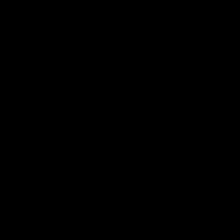

--------------------------------------------------
Test: text input 'canine'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Softmax output vector (image input): [0.1954592  0.18708768 0.19033438 0.19931442 0.22780435]
Gate weights (image input): [1. 0.]
Input: text='canine', image_present=0.0
Predicted sound for 'canine': bark


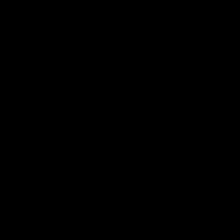

--------------------------------------------------
Test: text input 'wolf'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Softmax output vector (image input): [0.19798198 0.19185448 0.19242394 0.2067946  0.21094501]
Gate weights (image input): [1. 0.]
Input: text='wolf', image_present=0.0
Predicted sound for 'wolf': bark


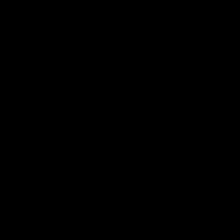

--------------------------------------------------
Test: text input 'cat'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Softmax output vector (image input): [0.19148226 0.18819055 0.18373652 0.2427513  0.19383937]
Gate weights (image input): [1. 0.]
Input: text='cat', image_present=0.0
Predicted sound for 'cat': meow


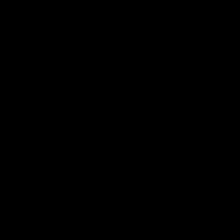

--------------------------------------------------
Test: text input 'feline'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Softmax output vector (image input): [0.19473724 0.18998025 0.18924785 0.22700404 0.19903067]
Gate weights (image input): [1. 0.]
Input: text='feline', image_present=0.0
Predicted sound for 'feline': meow


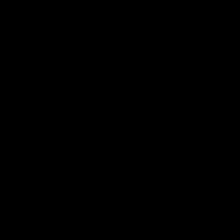

--------------------------------------------------
Test: text input 'tiger'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Softmax output vector (image input): [0.19751565 0.19246356 0.1926602  0.21653678 0.20082384]
Gate weights (image input): [1. 0.]
Input: text='tiger', image_present=0.0
Predicted sound for 'tiger': meow


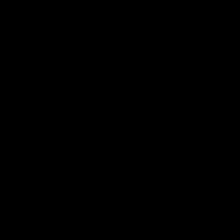

--------------------------------------------------
Test: text input 'puma'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Softmax output vector (image input): [0.19666193 0.19423442 0.19441389 0.20880951 0.20588025]
Gate weights (image input): [1. 0.]
Input: text='puma', image_present=0.0
Predicted sound for 'puma': meow


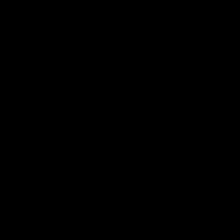

--------------------------------------------------
Test: image of cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Softmax output vector (image input): [0.14992084 0.39592227 0.15431514 0.14992084 0.14992084]
Gate weights (image input): [0. 1.]
Input: text='<empty>', image_present=1.0
Predicted animal: cat
Predicted sound for 'cat': meow


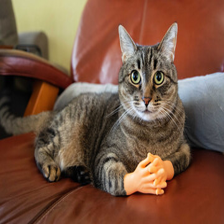

--------------------------------------------------
Test: image of dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Softmax output vector (image input): [0.14884797 0.1488495  0.40460658 0.14884797 0.14884797]
Gate weights (image input): [0. 1.]
Input: text='<empty>', image_present=1.0
Predicted animal: dog
Predicted sound for 'dog': bark


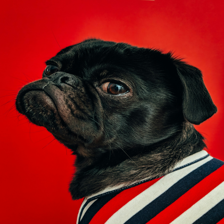

--------------------------------------------------
Test: text 'cat' and image cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Softmax output vector (image input): [0.14992084 0.39592227 0.15431514 0.14992084 0.14992084]
Gate weights (image input): [0. 1.]
Input: text='cat', image_present=1.0
Predicted animal: cat
Predicted sound for 'cat': meow


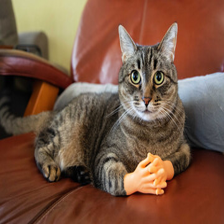

--------------------------------------------------
Test: text 'cat' and image dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Softmax output vector (image input): [0.14884797 0.1488495  0.40460658 0.14884797 0.14884797]
Gate weights (image input): [0. 1.]
Input: text='cat', image_present=1.0
Predicted animal: dog
Predicted sound for 'dog': bark


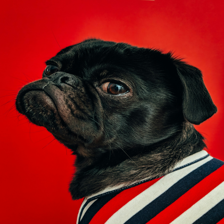

--------------------------------------------------
Test: text 'dog' and image dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Softmax output vector (image input): [0.14884797 0.1488495  0.40460658 0.14884797 0.14884797]
Gate weights (image input): [0. 1.]
Input: text='dog', image_present=1.0
Predicted animal: dog
Predicted sound for 'dog': bark


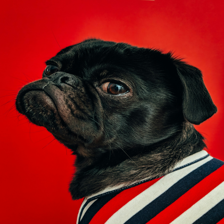

--------------------------------------------------
Test: text 'dog' and image cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Softmax output vector (image input): [0.14992084 0.39592227 0.15431514 0.14992084 0.14992084]
Gate weights (image input): [0. 1.]
Input: text='dog', image_present=1.0
Predicted animal: cat
Predicted sound for 'cat': meow


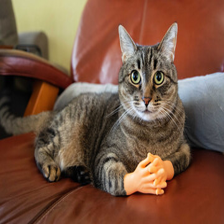

--------------------------------------------------


('cat', 'meow')

In [77]:
from PIL import Image
import requests
import io
import numpy as np
import tensorflow as tf

def predict_with_restored_model(text_input=None, image_input=None):
    if not text_input:
        text_input = dummy_text
    if image_input is None:
        image_input = dummy_image

    original_image = image_input.copy()

    # Ensure image shape and channels
    if image_input.ndim == 3 and image_input.shape[2] == 1:
        image_input = np.concatenate([image_input]*3, axis=2)
    if image_input.shape != (224, 224, 3):
        image_input = tf.image.resize(image_input, (224, 224)).numpy()

    # Prepare input batches
    text_batch = tf.constant([text_input])
    image_batch = np.expand_dims(image_input, axis=0)
    text_present = np.array([[0.0]], dtype=np.float32) if text_input == dummy_text else np.array([[1.0]], dtype=np.float32)
    image_present = np.array([[0.0]], dtype=np.float32) if np.all(image_input == 0) else np.array([[1.0]], dtype=np.float32)

    preds, gate_weights, _, _ = restored_model.predict([text_batch, image_batch, text_present, image_present], batch_size=1)

    gate_weights = np.squeeze(gate_weights)
    preds = np.squeeze(preds)

    pred_animal = None
    pred_sound = None

    if gate_weights[1] > gate_weights[0]:  # Image expert
        pred_id = np.argmax(preds[:len(animal_vocab)])
        pred_animal = inv_animal_vocab.get(pred_id, "unknown")
    else:  # Text expert
        pred_id = np.argmax(preds)
        pred_sound = inv_sound_vocab.get(pred_id, "unknown")

    if image_present[0,0] == 1.0:
        # Predict sound based on detected animal
        sound_text_batch = tf.constant([pred_animal if pred_animal else dummy_text])
        sound_image_batch = np.zeros((1,224,224,3), dtype=np.float32)
        sound_text_present = np.array([[1.0]], dtype=np.float32)
        sound_image_present = np.array([[0.0]], dtype=np.float32)

        sound_preds, _, _, _ = restored_model.predict([sound_text_batch, sound_image_batch, sound_text_present, sound_image_present], batch_size=1)
        sound_preds = np.squeeze(sound_preds)
        sound_pred_id = np.argmax(sound_preds)
        pred_sound = inv_sound_vocab.get(sound_pred_id, "unknown")

    print(f"Softmax output vector (image input): {preds}")
    print(f"Gate weights (image input): {gate_weights}")
    print(f"Input: text='{text_input}', image_present={image_present[0,0]}")
    if pred_animal:
        print(f"Predicted animal: {pred_animal}")
    if pred_sound:
        print(f"Predicted sound for '{pred_animal or text_input}': {pred_sound}")

    # Show original image
    display(Image.fromarray(np.uint8(original_image * 255)))
    print("-" * 50)

    return pred_animal, pred_sound


# Example real image test (you may replace URL with your own image links)
def load_image(url):
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content)).convert('RGB')
    img = img.resize((224,224))
    img_array = np.array(img) / 255.0
    return img_array

cat_img_url = "https://t3.ftcdn.net/jpg/04/73/67/64/240_F_473676400_VyH1ey15WGBA6L9MILjha6thtMVfuRh2.jpg"
dog_img_url = "https://images.unsplash.com/photo-1517423440428-a5a00ad493e8"


# Example Tests

print("Test: text input 'dog'")
predict_with_restored_model(text_input="dog")

print("Test: text input 'canine'")
predict_with_restored_model(text_input="canine")

print("Test: text input 'wolf'")
predict_with_restored_model(text_input="wolf")

print("Test: text input 'cat'")
predict_with_restored_model(text_input="cat")

print("Test: text input 'feline'")
predict_with_restored_model(text_input="feline")

print("Test: text input 'tiger'")
predict_with_restored_model(text_input="tiger")

print("Test: text input 'puma'")
predict_with_restored_model(text_input="puma")

print("Test: image of cat")
predict_with_restored_model(image_input=load_image(cat_img_url))

print("Test: image of dog")
predict_with_restored_model(image_input=load_image(dog_img_url))

print("Test: text 'cat' and image cat")
predict_with_restored_model(text_input="cat", image_input=load_image(cat_img_url))

print("Test: text 'cat' and image dog")
predict_with_restored_model(text_input="cat", image_input=load_image(dog_img_url))

print("Test: text 'dog' and image dog")
predict_with_restored_model(text_input="dog", image_input=load_image(dog_img_url))

print("Test: text 'dog' and image cat")
predict_with_restored_model(text_input="dog", image_input=load_image(cat_img_url))

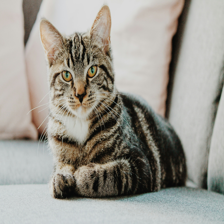

In [68]:
test_image_array = load_image(cat_img_url)
# display image
display(Image.fromarray(np.uint8(test_image_array * 255)))